# Optimization of the hypermarameters of MLP using GA

**Dataset Loading, selecting and normalizing**

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

# Filtering the data getting only 0s and
train_filter = np.where((y_train_full == 0) | (y_train_full == 1))

X_train_full, y_train_full = X_train_full[train_filter], y_train_full[train_filter]

# Normalize the pixel values
X_train_full = X_train_full.astype('float32') / 255.0

# Flatten the images
X_train_full = X_train_full.reshape(X_train_full.shape[0], -1)

X_train, X_temp, y_train, y_temp = train_test_split(X_train_full, y_train_full, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [11]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 7599
Validation set size: 2533
Test set size: 2533


**Printing a temple of 0 and 1 form the dataset**

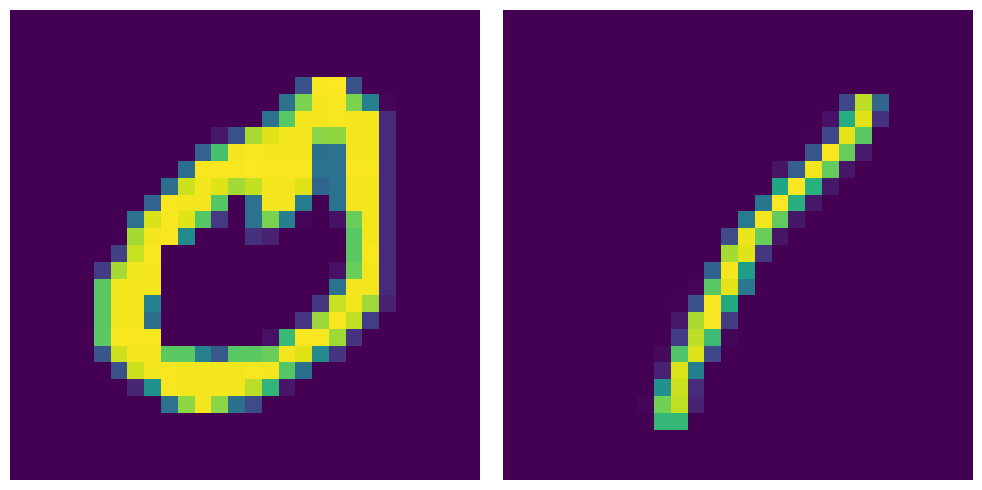

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image1 = mpimg.imread("mnist_images\\image_4.png")
image2 = mpimg.imread("mnist_images\\image_12663.png")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

axes[0].imshow(image1)
axes[0].axis('off') 

axes[1].imshow(image2)
axes[1].axis('off') 

plt.tight_layout() 
plt.show()

**Using the MLP before the optimization**

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, alpha=0.0001,
                    solver='adam', verbose=10, random_state=42,
                    learning_rate_init=0.01)

mlp.fit(X_train.reshape(X_train.shape[0], -1), y_train)

y_pred = mlp.predict(X_test.reshape(X_test.shape[0], -1))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Iteration 1, loss = 0.03932555
Iteration 2, loss = 0.00346917
Iteration 3, loss = 0.00210023
Iteration 4, loss = 0.00171234
Iteration 5, loss = 0.00114470
Iteration 6, loss = 0.00043892
Iteration 7, loss = 0.00041760
Iteration 8, loss = 0.00017650
Iteration 9, loss = 0.00013758
Iteration 10, loss = 0.00012392
Iteration 11, loss = 0.00011358
Iteration 12, loss = 0.00010062
Iteration 13, loss = 0.00009322
Iteration 14, loss = 0.00008725
Iteration 15, loss = 0.00008298
Iteration 16, loss = 0.00008063
Iteration 17, loss = 0.00007707
Iteration 18, loss = 0.00007548
Iteration 19, loss = 0.00007303
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.9988


**Visualization of the loss of each iteration**

In [14]:
import plotly.graph_objects as go

loss_history = mlp.loss_curve_

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(loss_history))), y=loss_history, mode='lines', name='Training Loss', line=dict(color='royalblue')))

fig.update_xaxes(showline=True, linewidth=2, linecolor='white', mirror=True, gridcolor='purple', gridwidth=0.5)
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', mirror=True, gridcolor='purple', gridwidth=0.5)
fig.update_layout(
    title="Training Loss Over Iterations",
    xaxis_title="Iterations",
    yaxis_title="Training Loss",
    paper_bgcolor = 'rgba(0,0,0,0)', 
    plot_bgcolor = 'rgba(0,0,0,0)',
    font=dict(color="white"),
)

**Genetic Algorithm methods**

In [15]:
# transformation of the 2D matrix to a list 
def flatten_weights_biaises(model):
    weights = []
    biaises = []
    for weight, biais in zip(model.coefs_, model.intercepts_):
        weights.extend(weight.flatten())
        biaises.extend(biais)
    return weights, biaises

In [16]:
import random

# optimization of the weights and biaises
def set_weights(model, weights, biaises):
    start_w = 0
    start_b = 0
    new_weights = []
    new_biaises = []
    
    for weight, biais in zip(model.coefs_, model.intercepts_):
        weight_shape = weight.shape
        weight_size = np.prod(weight_shape)
        end_w = start_w + weight_size
        new_weight = np.array(weights[start_w:end_w]).reshape(weight_shape)
        start_w += weight_size
        
        bias_shape = biais.shape
        biais_size = np.prod(bias_shape)
        end_b = start_b + biais_size
        new_biais = np.array(biaises[start_b:end_b]).reshape(bias_shape)
        
        new_weights.append(new_weight)
        new_biaises.append(new_biais)
    
    model.coefs_ = new_weights
    model.intercepts_ = new_biaises

def fitness_function(chromosome, X_train, y_train, X_val, y_val):
    hidden_layer_size = int(chromosome[0])
    learning_rate = np.abs(chromosome[1])
    alpha = chromosome[2]
    weights = chromosome[3]
    biases = chromosome[4]
    
    model = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,), learning_rate_init=learning_rate, alpha=alpha, max_iter=1, warm_start=True)
    model.fit(X_train, y_train)
    set_weights(model, weights, biases)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return accuracy_score(y_val, y_pred)

def initialize_population(pop_size, model):
    population = []
    for _ in range(pop_size):
        hls = model.hidden_layer_sizes[0]
        learning_rate_init = model.learning_rate_init
        alpha = model.alpha
        weights, biases = flatten_weights_biaises(model)
        chromosome = [hls, learning_rate_init, alpha, weights, biases]
        population.append(chromosome)
    return population

def select_parents(population, fitnesses):
    total_fitness = sum(fitnesses)
    selection_probs = [fitness / total_fitness for fitness in fitnesses]
    parents = random.choices(population, weights=selection_probs, k=len(population))
    return parents

def crossover(parent1, parent2):
    def multiply_nested_list(element, a):
        result = []
        if isinstance(element, list):
            for item in element:
                result.append(item * a)
            return result
        return element * a
    
    alpha  = random.random() # generates numbers between 0 and 1
    child1 = [multiply_nested_list(p1, alpha) + multiply_nested_list(p2, 1 - alpha) for p1, p2 in zip(parent1, parent2)]
    child2 = [multiply_nested_list(p1, 1 - alpha) + multiply_nested_list(p2, alpha) for p1, p2 in zip(parent1, parent2)]
    
    return child1, child2

def mutate(population):
    def mutate_chromosome(chromosome):
        gene_index = random.randint(0, len(chromosome) - 1)
        mutation_value = random.uniform(0, 0.1) 
        if isinstance(chromosome[gene_index], list):
            index = random.randint(0, len(chromosome[gene_index]) - 1)
            chromosome[gene_index][index] += mutation_value
        else:
            chromosome[gene_index] += mutation_value
        
        return chromosome
    
    chromosome_index = random.randint(0, len(population) - 1)
    chromosome = population[chromosome_index]
    mutated_chromosome = mutate_chromosome(chromosome)
    population[chromosome_index] = mutated_chromosome  
    return population
                
def genetic_algorithm(X_train, y_train, X_val, y_val, pop_size, generations):
    model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=10, warm_start=True)
    model.fit(X_train, y_train)
    population = initialize_population(pop_size, model)
    fitness_history = []
    best_chromosome_per_generation = []
    for _ in range(generations):
        fitnesses = [fitness_function(chromosome, X_train, y_train, X_val, y_val) for chromosome in population]
        fitness_history.append(max(fitnesses))
        best_params = population[fitnesses.index(max(fitnesses))]
        best_chromosome_per_generation.append((best_params, 1 - max(fitnesses)))
        parents = select_parents(population, fitnesses)
        next_population = []
        for i in range(0, len(parents)-1, 2):
            parent1, parent2 = parents[i], parents[i + 1]
            child1, child2 = crossover(parent1, parent2)
            next_population.extend([child1, child2])
        mutate(next_population)
        population = next_population
    best_chromosome = max(population, key=lambda chromo: fitness_function(model, X_val, y_val))
    return best_chromosome, fitness_history, best_chromosome_per_generation

In [ ]:
pop_size = 5
generations = 10

best_solution, fitness_history, best_chromosome_per_generation= genetic_algorithm(X_train, y_train, X_val, y_val, pop_size, generations)
print("Best solution:", best_solution)

for generation, (params, error) in enumerate(best_chromosome_per_generation):
    print(f"Generation {generation + 1}: Best Params: {params}, Error: {error:.4f}")

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.

c:\Users\HP\AppData\Local\Programs\

MemoryError: 

In [ ]:
# Evaluate the final model on the test dataset
hidden_layer_size = int(best_solution[0])
learning_rate_init = best_solution[1]
alpha = best_solution[2]
weights = best_solution[3]
biaises = best_solution[4]

final_model = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,), learning_rate='constant', learning_rate_init=learning_rate_init, alpha=alpha, max_iter=200, warm_start=True)
final_model.fit(X_train, y_train)
set_weights(final_model, weights, biaises)
y_test_pred = final_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Test accuracy:", test_accuracy)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(fitness_history))), y=fitness_history, mode='lines', name='Fitness', line=dict(color='blue')))
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, gridcolor='purple', gridwidth=0.5)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True, gridcolor='purple', gridwidth=0.5)
fig.update_layout(
    title="Fitness Evolution Over Generations",
    xaxis_title="Generations",
    yaxis_title="Fitness",
    paper_bgcolor = 'rgba(0,0,0,0)', 
    plot_bgcolor = 'rgba(0,0,0,0)',
    font=dict(color="white"),
)

fig.show()

In [ ]:
errors_per_generation = [error for _, error in best_chromosome_per_generation]

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(errors_per_generation))), y=errors_per_generation, mode='lines+markers', name='Errors per generations', line=dict(color='violet'), marker=dict(symbol='circle', size=8, color='grey')))

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, gridcolor='purple', gridwidth=0.5)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True, gridcolor='purple', gridwidth=0.5)
fig.update_layout(
    title="Evolution of Minimum Classification Error Over Generations",
    xaxis_title="Generations",
    yaxis_title="Classification Error",
    paper_bgcolor = 'rgba(0,0,0,0)', 
    plot_bgcolor = 'rgba(0,0,0,0)',
    font=dict(color="white"),
)

fig.show()

In [ ]:
# Précision du MLP seul
accuracy_mlp_seul = accuracy

# Précision du MLP optimisé par AG
accuracy_mlp_optimise = test_accuracy

# Afficher les résultats
print(f"Précision du MLP seul: {accuracy_mlp_seul:.4f}")
print(f"Précision du MLP optimisé par AG: {accuracy_mlp_optimise:.4f}")

# Comparer les résultats
if accuracy_mlp_optimise > accuracy_mlp_seul:
    print("Le MLP optimisé par AG a une meilleure précision que le MLP seul.")
elif accuracy_mlp_optimise < accuracy_mlp_seul:
    print("Le MLP seul a une meilleure précision que le MLP optimisé par AG.")
else:
    print("Les deux modèles ont la même précision.")